In [1]:
!pip install datasets

Restart notebook

# Dataset exploration

In [2]:
import itertools
from collections import Counter, OrderedDict

import numpy as np
import datasets
from transformers import AutoTokenizer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from datasets import Dataset


plt.rcParams["figure.figsize"] = (8, 6)

## Load dataset from the Huggingface repository.

In [3]:
dataset = load_dataset('Babelscape/multinerd')
dataset

Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'lang'],
        num_rows: 2678400
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'lang'],
        num_rows: 334800
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'lang'],
        num_rows: 335986
    })
})

## Define the classes from the dataset description.

In [4]:
key2index = {
    "O": 0,
    "B-PER": 1,
    "I-PER": 2,
    "B-ORG": 3,
    "I-ORG": 4,
    "B-LOC": 5,
    "I-LOC": 6,
    "B-ANIM": 7,
    "I-ANIM": 8,
    "B-BIO": 9,
    "I-BIO": 10,
    "B-CEL": 11,
    "I-CEL": 12,
    "B-DIS": 13,
    "I-DIS": 14,
    "B-EVE": 15,
    "I-EVE": 16,
    "B-FOOD": 17,
    "I-FOOD": 18,
    "B-INST": 19,
    "I-INST": 20,
    "B-MEDIA": 21,
    "I-MEDIA": 22,
    "B-MYTH": 23,
    "I-MYTH": 24,
    "B-PLANT": 25,
    "I-PLANT": 26,
    "B-TIME": 27,
    "I-TIME": 28,
    "B-VEHI": 29,
    "I-VEHI": 30,
  }
index2key = {value: key for key, value in key2index.items()}
entity2index = {key.split('-')[-1]: value for key, value in key2index.items() if 'B-' in key}
index2entity = {value: key for key, value in entity2index.items()}

## Filter out non english samples.

In [5]:
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']

train_dataset = train_dataset.filter(lambda example: example["lang"].startswith("en"))
validation_dataset = validation_dataset.filter(lambda example: example["lang"].startswith("en"))
test_dataset = test_dataset.filter(lambda example: example["lang"].startswith("en"))
train_dataset

Dataset({
    features: ['tokens', 'ner_tags', 'lang'],
    num_rows: 262560
})

## Compute the ratio of named entities in the dataset against the out-of-scope text "O"

In [6]:
entities_list = list(itertools.chain(*dataset['train']['ner_tags']))
entity_counts = OrderedDict(sorted(Counter(entities_list).items()))
entity_sum = sum(entity_counts.values())
ratios = [round(x/entity_sum, 3) for x in entity_counts.values()]
values = [ratios[0], sum(ratios[1:])]
columns = ['O', 'Entities']
col_val_dict = {'O': values[0],
                'Entites': values[-1]
                }
plotdata = pd.DataFrame(col_val_dict, index=['entities vs "O"'])
plotdata

,O,Entites
"entities vs ""O""",0.86,0.136


### Entitity vs "O" ratios

<Axes: >

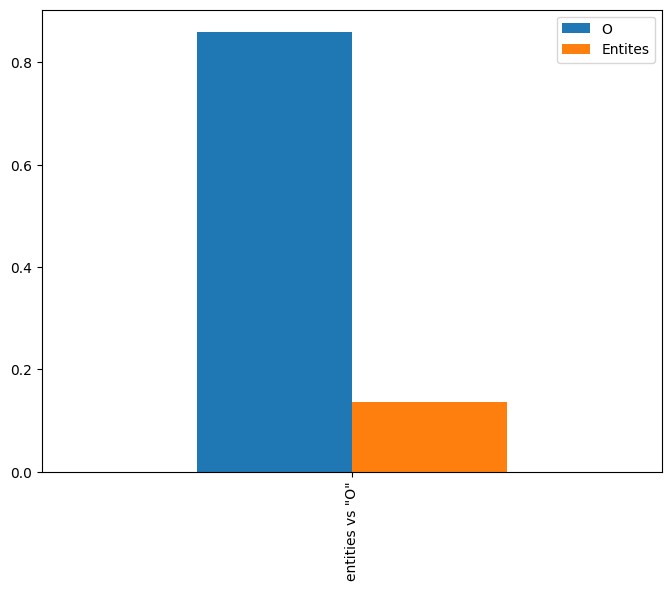

In [7]:
plotdata.plot(kind='bar')

## Compute the distribution of named entities to each class.

In [8]:
entities_list = list(itertools.chain(*dataset['train']['ner_tags']))
entities_list = [x for x in entities_list if x != 0]
entities_list = [index2key[x].split('-')[-1] for x in entities_list]
entity_counts = OrderedDict(sorted(Counter(entities_list).items()))
entity_sum = sum(entity_counts.values())
values = [round(y/entity_sum, 3) for x, y in entity_counts.items()]
columns = entity_counts.keys()
col_val_dict = {key: value for key, value in zip(columns, values)}
col_val_dict = {k: v for k, v in sorted(col_val_dict.items(), key=lambda item: item[1], reverse=True)}
plotdata = pd.DataFrame(col_val_dict, index=['ratio'])
plotdata

,PER,LOC,ORG,MEDIA,TIME,ANIM,EVE,PLANT,DIS,FOOD,CEL,MYTH,INST,VEHI,BIO
ratio,0.322,0.253,0.121,0.085,0.064,0.054,0.035,0.019,0.017,0.012,0.009,0.004,0.003,0.002,0.001


### Entity population ratio plot

Text(0, 0.5, 'ratio of entity')

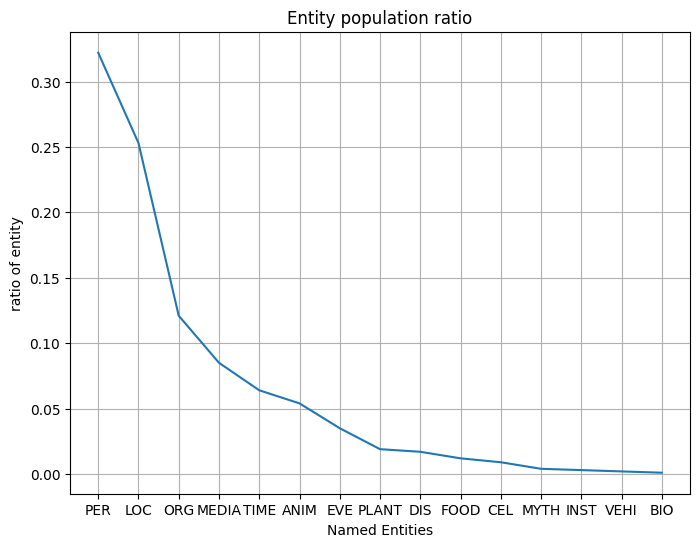

In [9]:
plt.plot(col_val_dict.values())
plt.xticks(range(len(col_val_dict.keys())), list(col_val_dict.keys()))
plt.grid()
plt.title("Entity population ratio")
plt.xlabel("Named Entities")
plt.ylabel("ratio of entity")

### Entity population cumulative sum

Text(0, 0.5, 'cumulative sum of entity ratios')

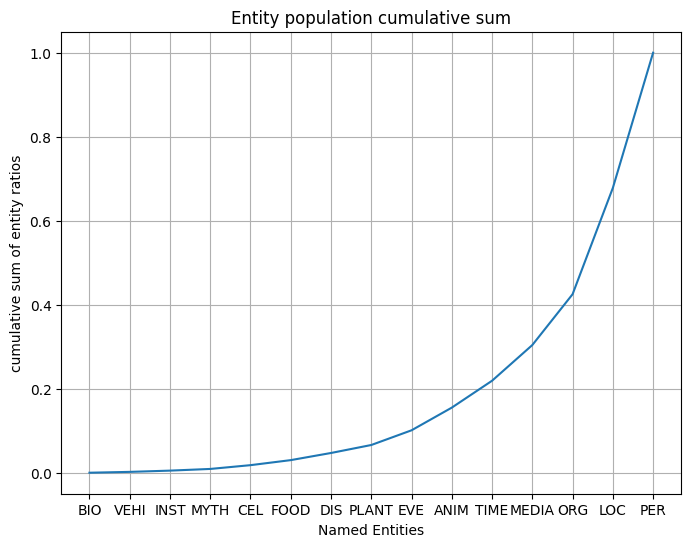

In [10]:
col_val_dict = {k: v for k, v in sorted(col_val_dict.items(), key=lambda item: item[1])}
plt.plot(np.cumsum(list(col_val_dict.values())))
plt.xticks(range(len(col_val_dict.keys())), list(col_val_dict.keys()))
plt.grid()
plt.title("Entity population cumulative sum")
plt.xlabel("Named Entities")
plt.ylabel("cumulative sum of entity ratios")


## Average length in words for each entity in the samples.

In [11]:
dataset_tags = dataset['train']['ner_tags']
dataset_tags = [[index2key[x].split('-')[-1] for x in sample_tags if x != 0] for sample_tags in dataset_tags]
total_entities_lens = {}
for entity in entity2index:
  entity_lens = []
  for sample in dataset_tags:
    count = sample.count(entity)
    if count > 0:
      entity_lens.append(count)
  total_entities_lens[entity] = round(np.mean(entity_lens), 1)
total_entities_lens = {k: v for k, v in sorted(total_entities_lens.items(), key=lambda item: item[1], reverse=True)}
plotdata = pd.DataFrame(total_entities_lens, index=['entity average length'])
plotdata

,MEDIA,EVE,PER,ORG,INST,VEHI,LOC,BIO,ANIM,CEL,MYTH,PLANT,DIS,FOOD,TIME
entity average length,4.7,3.4,3.3,2.9,2.7,2.7,2.6,2.5,2.4,2.1,2.1,2.1,2.0,1.8,1.5


## Average sample lengths in words and in tokens for the chosen model, RoBERTa-base for the English language.

In [12]:
tokenizer = tokenizer = AutoTokenizer.from_pretrained(
    "roberta-base",
    model_max_length=512,
    max_len=512,
    truncation=True,
    add_prefix_space=True,
    padding='Longest')

In [13]:
def preprocess_data(examples):
  """
  Processes text with the model tokenizer
  """
  text = examples['tokens']
  encodings = tokenizer(
      text,
      is_split_into_words=True,
      return_offsets_mapping=True,
      padding=True,
      truncation=True
      )
  return encodings

In [14]:
train_dataset = train_dataset.map(preprocess_data, batched=False, remove_columns=['tokens', 'lang'])

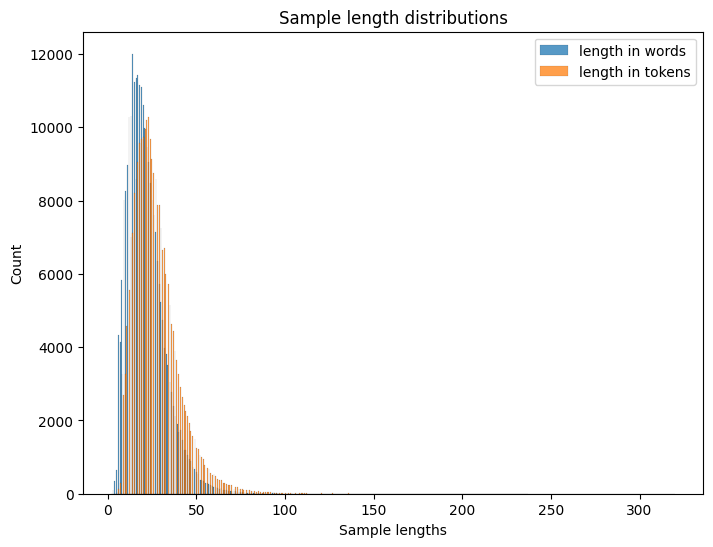

In [15]:
sample_lengths = [len(x) for x in train_dataset['ner_tags']]
tokenized_sample_lengths = [len(x) for x in train_dataset['input_ids']]
sns.histplot(sample_lengths, label='length in words')
sns.histplot(tokenized_sample_lengths, label='length in tokens')
plt.xlabel("Sample lengths")
plt.title("Sample length distributions")
plt.legend()